# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [21]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':1000000,#200000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [22]:
folder = "unbias/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# definition of Deep-TICA cvs 
deep: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=p.x,p.y

# Bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=deep.node-0,deep.node-1,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
#execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

## Unbias Trajectory 

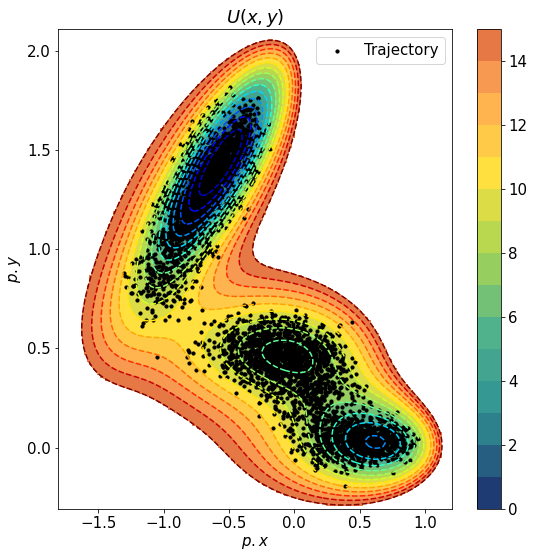

In [79]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values,load_dataframe(folder+"COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energu Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

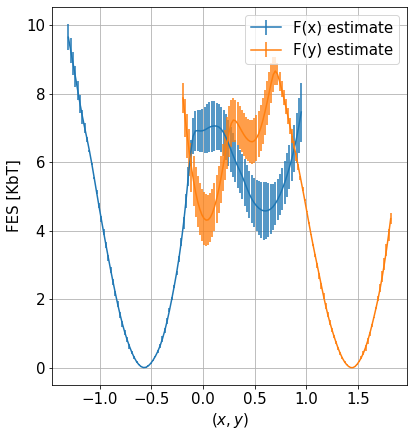

In [23]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Bi-dimensional estimation of Free Energy Surface

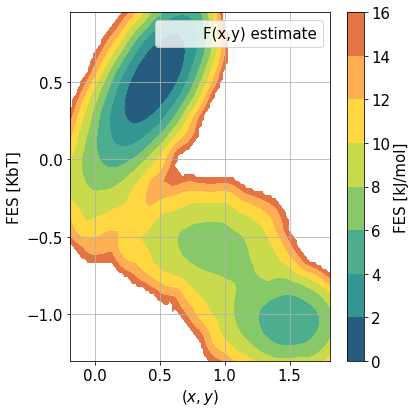

In [29]:
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
s[:, [1, 0]] = s[:, [0, 1]]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))

fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x,y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

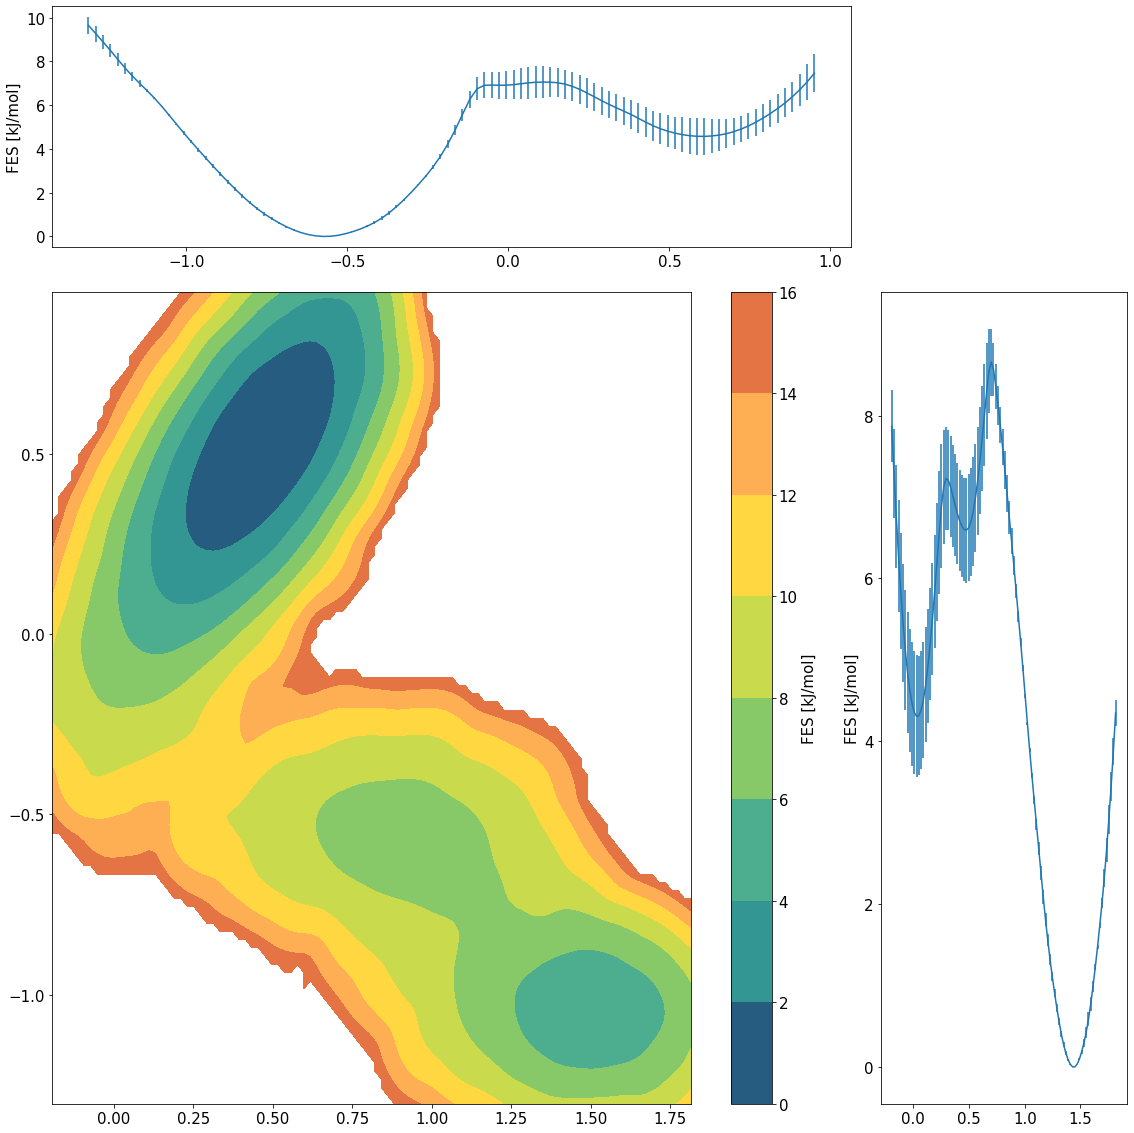

In [39]:
from matplotlib import transforms

fig = plt.figure(figsize=(16,16))
gs = GridSpec(4, 4)#, figure=fig)

#base = pyplot.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)

ax_scatter = fig.add_subplot(gs[1:4,0:3])
ax_hist_x = fig.add_subplot(gs[0,:3])
ax_hist_y = fig.add_subplot(gs[1:,3])

fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)

ax_hist_y.set_transform(rot) #+ base)

plt.tight_layout()
plt.show()

## Bias simulation DeepTICA Analysis and Export  
  
Before performing the next training we have to choose the `lag_time` again.  
Obviously one can think to look again at $C(\tau)$, but we must remember that now we are performing a biased simulation, an the time is *accelerated*.  
  
We can compute the time autocorrelation using the rescale time $d t \prime = d t e^{\beta V(\vec cv (\vec x))}$

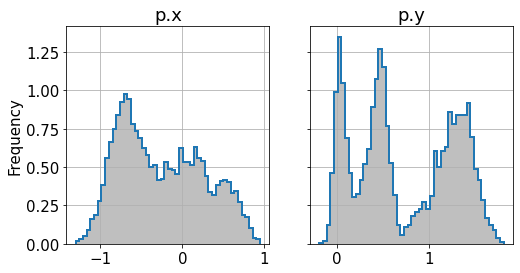

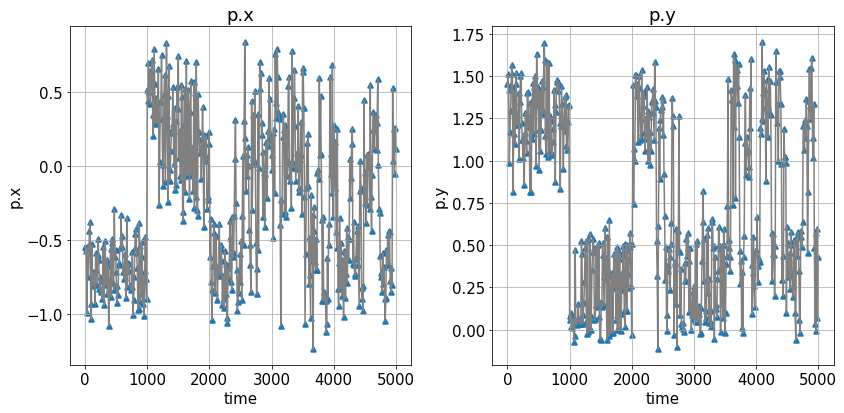

In [83]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

autocorrelation for  p.x
autocorrelation for  p.y


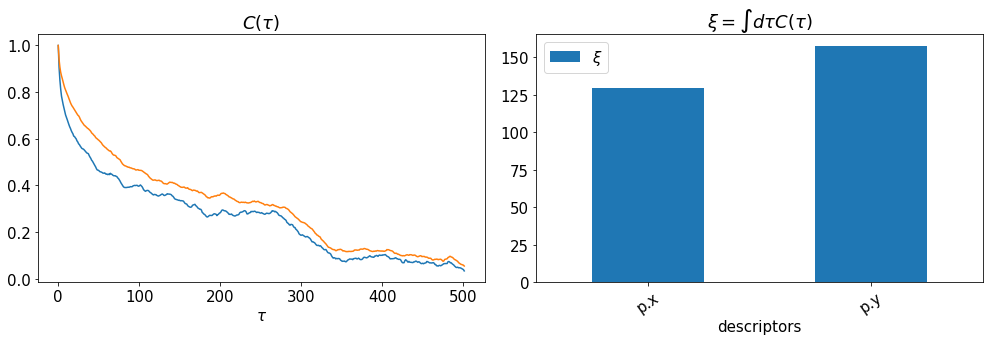

157.31192322879636
129.58520271130126


In [84]:
fig,axs = plt.subplots(1,2,figsize=(14,5))#,sharey=True)

#-- in ps --#
last=500
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#fit_timeacorr(descriptors_names,data,axs=None)

It is really difficult to estimate a good $\tau$.  
I have to implement the time auto-correlation function

In [85]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':2,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [86]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

Time-lagged pairs:	 9944
Training data:		 6960
Validation data:	 2984
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.842      -0.833      0.805  0.013  
100   -0.860      -0.867      0.807  0.052  
150   -0.866      -0.875      0.809  0.054  
200   -0.874      -0.885      0.813  0.056  
INFO: Early stopping
246   -0.882      -0.897      0.821  0.058  
model saved
timescales:  [10.136329   0.7020558]
eigenvalues:  [0.820936   0.05791514]


## Load existing model  
  
I recall that it is always possible to load an existing model  

```py
data = load_dataframe(folder+"COLVAR")
search_values="^p."
X, t, logweight = data.filter(regex=search_values).values, data['time'].to_numpy(). data["opes.bias"].to_numpy()

logweight = ( logweight-max(logweight) ) / sim_parameters["temp"]

model = DeepTICA_CV(train_parameters["nodes"],activation=train_parameters['activ_type'])
model.load_checkpoint(folder+"deeptica/model_checkpoint.pt")
```

In [87]:
#-- plot model loss function --#
def plot_model_lossfunction(model):

    n_eig=len(model.nn[-1].bias)

    fig, axs = plt.subplots(1,2,figsize=(12,5))#,dpi=100)

    loss_train = [x.cpu() for x in model.loss_train]
    loss_valid = [x.cpu() for x in model.loss_valid]

    # Loss function
    ax = axs[0]
    ax.plot(loss_train,'-',label='Train')
    ax.plot(loss_valid,'--',label='Valid')
    ax.set_ylabel('Loss Function')

    # Eigenvalues vs epoch
    ax = axs[1]
    with torch.no_grad():
        evals_train = np.asarray(torch.cat(model.evals_train).cpu())
    for i in range(n_eig):
        ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
    ax.set_ylabel('Eigenvalues')
    
    # Common setup
    for ax in axs:
        if model.earlystopping_.best_epoch is not None:
            if model.earlystopping_.early_stop:
                ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
                ax.set_xlabel('#Epochs')
                ax.legend(ncol=2)

    plt.tight_layout()

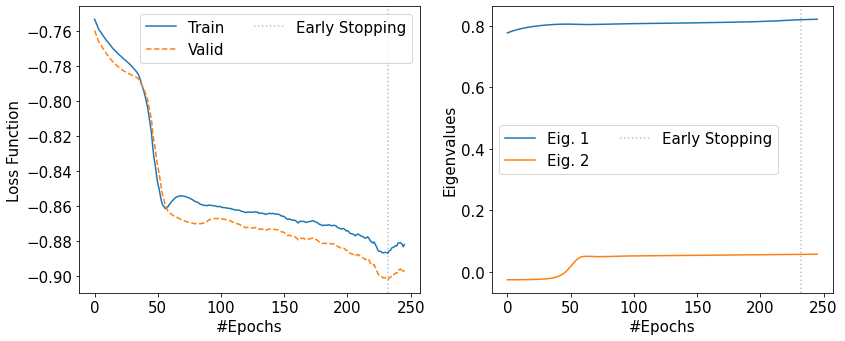

In [88]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [89]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

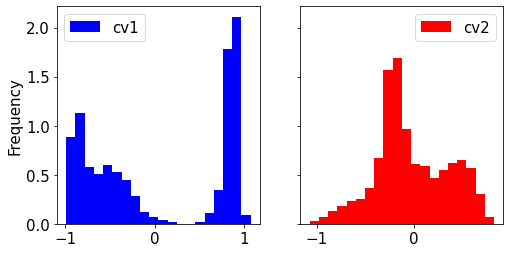

In [90]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

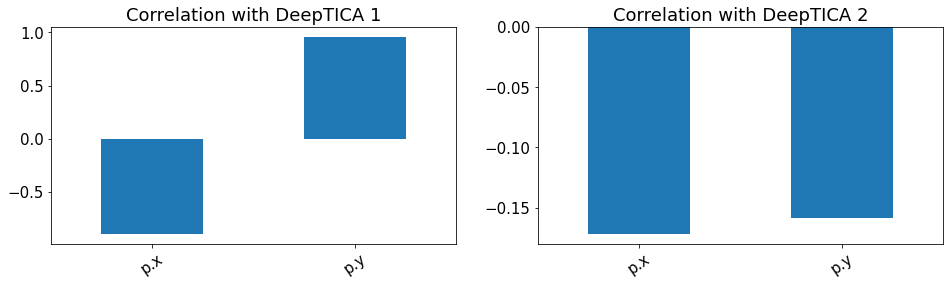

In [91]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from new cvs  

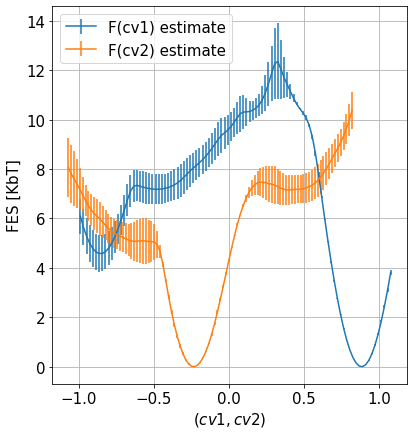

In [92]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Free Energy Estimation from sampled Deep-TICA Cvs

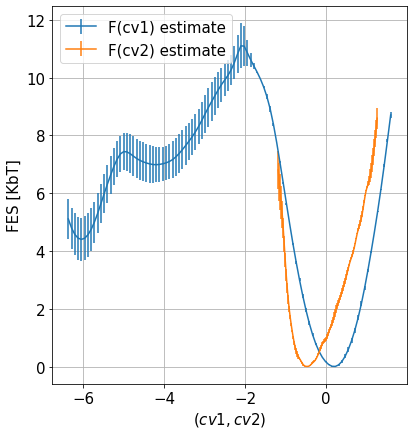

In [93]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^deep").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

In [94]:
def plot_cvs_isolines(model,limits,points=150,n_out=2,scatter=None,axs=None):

    #-- prepare grid --#
    xx,yy = np.meshgrid(np.linspace(limits[0][0],limits[0][1],points),np.linspace(limits[1][0],limits[1][1],points))
    grid = np.transpose(np.array([xx.reshape(points*points),yy.reshape(points*points)]))

    #-- evaluate cvs on the grid --#
    cvs = []
    for i in range(n_out):
        cvs.append(np.transpose(model(torch.Tensor(grid)).detach().cpu().numpy())[i].reshape(points,points))

    #-- plotting --#
    if axs is None:
        fig,axs = plt.subplots(1,n_out,figsize=(12,6))

    for k,ax in enumerate(axs):
        cset = ax.contourf(xx,yy,cvs[k],linewidths=1,cmap="fessa")
        cset = ax.contour(xx,yy,cvs[k],linewidths=3,cmap="gray",linestyles="dashed")
        ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=15)
        ax.set_xlabel("p.x")
        ax.set_ylabel("p.y")
        ax.set_title('Deep-TICA '+str(k+1))
        if scatter is not None:
            ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.8)
            ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

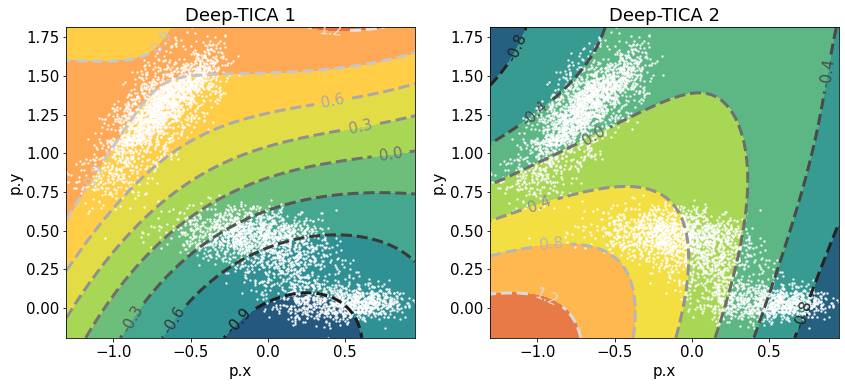

In [95]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

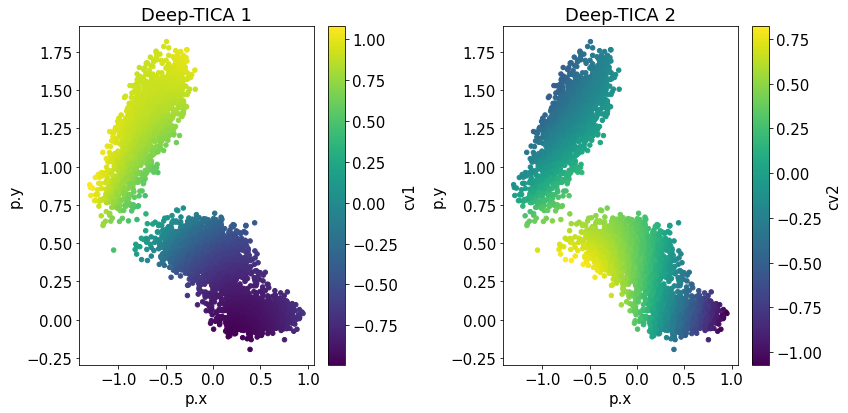

In [96]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
Now we want to estimate the scalar product of the Deep-TICA Cvs. In this case we have to reweight the integrale, because our points are distributed according to $p(\vec x) = \dfrac{e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))}}{\mathcal{Z}}$. Then finally the scalar product is computed from the following integral $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))} e^{\beta ( V(\vec cv(\vec x))}$.  
  
Even in this case, as already observed their scalar product on the data will lead to a result slightly different from $0$, due to the enforced simmetryzation of $C(\tau)$

In [97]:
def Boltzmann_product(model0,model1,X,j=0,k=1,logweight=None,normed=False):

    if logweight is not None:
            weights= np.exp(logweight)
    else:
        weights=np.ones(X.shape[0])

    a = np.transpose(model0(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model1(torch.Tensor(X)).detach().cpu().numpy())[k]
    sumtot = np.multiply(np.multiply(a,weights),b).mean()

    if normed:
        sumcv1 = np.multiply(np.multiply(a,weights),a).mean()
        sumcv2 = np.multiply(np.multiply(b,weights),b).mean()
        return sumtot/np.sqrt(sumcv1*sumcv2)
    else:
        return sumtot

In [98]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.006781155696417068

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [99]:
def orthogonal_cv(model,X,logweight=None,j=0,k=1):

    a = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[k]

    prod_ab = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=k)
    prod_aa = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=j) 

    c = b - prod_ab/(prod_aa) * a

    return c

#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X,logweight=logweight)
prod = np.multiply(np.multiply(cv1,np.exp(logweight)),new_cv2).mean()
print(prod)

1.3841731101747712e-10


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

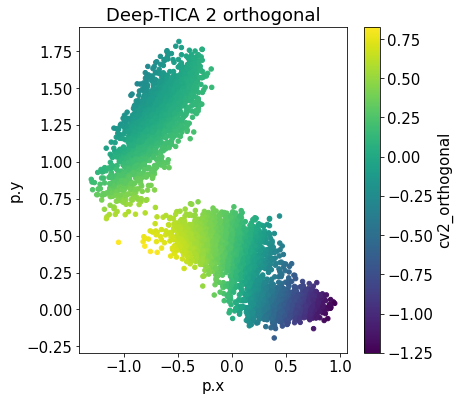

In [100]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="p.y",x="p.x",c="cv2_orthogonal",cmap="viridis",ax=ax)
ax.set_title('Deep-TICA 2 orthogonal')